In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.regularizers import l2  # import regularizer
from keras.datasets import imdb
from keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt

In [2]:
#HYPER PARAMETERS

EMBEDDING_DIM = 32
VOCABULARY_SIZE = 10000 #len(vocabulary)
SEQ_LENGTH = 500 # size of each review
INIT_LR = 1e-2 # Initial learning rate
LR_REDUCE = 0.1 # Learning rate Decay factor
BATCH_SIZE = 64 # mini-batch, between 16 & 128
NUM_EPOCHS = 50 # Arbitary Number
VAL_DATA = 0.20 # 20% of the train data

In [3]:
def download_datasets( vocabulary_size):
  ( x_train, y_train), (x_test,y_test) = imdb.load_data(num_words = vocabulary_size)
  return  ( x_train, y_train), (x_test,y_test)

In [ ]:
def preprocessing(x_train,x_test, seq_length):
  x_train = sequence.pad_sequences(x_train, maxlen= seq_length, padding= 'post', value = 0)
  x_test = sequence.pad_sequences(x_test, maxlen= seq_length, padding= 'post', value = 0)
  return x_train, x_test

In [ ]:
( x_train, y_train), (x_test,y_test) = download_datasets( VOCABULARY_SIZE)
x_train, x_test = preprocessing(x_train,x_test, SEQ_LENGTH)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
def get_model(vocabulary_size, embedding_dim, input_length, summary=True):
  inputs = layers.Input(shape=(input_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)
  b1 = layers.Conv1D(128, kernel_size=(3),padding='same',kernel_regularizer=l2(0.01), activation='relu')(x)
  b1 = layers.MaxPool1D(pool_size=(2))(b1)
  b1 = layers.Dropout(0.5)(b1)
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.LSTM(128, return_sequences=False)(b1)

  b2 = layers.Conv1D(128, kernel_size=(5),padding='same',kernel_regularizer=l2(0.01), activation='relu')(x)
  b2 = layers.MaxPool1D(pool_size=(2))(b2)
  b2 = layers.Dropout(0.5)(b2)
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.LSTM(128, return_sequences=False)(b2)


  b3 = layers.Conv1D(128, kernel_size=(7),padding='same',kernel_regularizer=l2(0.01), activation='relu')(x)
  b3 = layers.MaxPool1D(pool_size=(2))(b3)
  b3 = layers.Dropout(0.5)(b3)
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.LSTM(128, return_sequences=False)(b3)

  b4 = layers.Conv1D(128, kernel_size=(9),padding='same',kernel_regularizer=l2(0.01), activation='relu')(x)
  b4 = layers.MaxPool1D(pool_size=(2))(b4)
  b4 = layers.Dropout(0.5)(b4)
  b4 = layers.BatchNormalization()(b4)
  b4 = layers.LSTM(128, return_sequences=False)(b4)

  concat = layers.concatenate([b1, b2, b3, b4], name='Concatenate')

  out = layers.Dense(1, activation='sigmoid')(concat)


  model = Model(inputs, out, name='CNN-LSTM_with_Combined_Kernels_from_mltiple_branches')
  model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=INIT_LR), metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

In [ ]:
multi_branch_model = get_model(VOCABULARY_SIZE, EMBEDDING_DIM, SEQ_LENGTH)

Model: "CNN-LSTM_with_Combined_Kernels_from_mltiple_branches"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 32)      320000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 128)     12416       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 128)     20608       embedding[0][0]                  
_______________________________________________

In [ ]:

train_steps = np.ceil(int(np.round(len(x_train) * (1 - VAL_DATA))) / BATCH_SIZE)
val_steps = np.ceil(int(np.round(len(x_train) * VAL_DATA)) / BATCH_SIZE)

In [ ]:
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.1
	epochs_drop = 1.0
  
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

StopCbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,verbose=1)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=5,
                                                           min_lr=1e-5)

In [ ]:
history = multi_branch_model.fit(x_train, y_train, 
                                 epochs=NUM_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 callbacks=[StopCbk, reduce_lr_on_plateu],
                                 validation_split= VAL_DATA,
                                 verbose=1)

Epoch 1/50
313/313 [==============================] - 41s 91ms/step - loss: 1.0271 - accuracy: 0.5012 - val_loss: 0.7967 - val_accuracy: 0.5062
Epoch 2/50
313/313 [==============================] - 27s 86ms/step - loss: 0.7270 - accuracy: 0.5000 - val_loss: 0.7462 - val_accuracy: 0.5098
Epoch 3/50
313/313 [==============================] - 27s 87ms/step - loss: 0.7309 - accuracy: 0.5097 - val_loss: 0.7331 - val_accuracy: 0.5090
Epoch 4/50
313/313 [==============================] - 27s 87ms/step - loss: 0.7381 - accuracy: 0.5171 - val_loss: 0.7606 - val_accuracy: 0.5084
Epoch 5/50
313/313 [==============================] - 27s 87ms/step - loss: 0.7451 - accuracy: 0.5097 - val_loss: 0.7499 - val_accuracy: 0.4754
Epoch 6/50
313/313 [==============================] - 27s 88ms/step - loss: 0.7543 - accuracy: 0.5655 - val_loss: 0.7048 - val_accuracy: 0.7526
Epoch 7/50
313/313 [==============================] - 27s 88ms/step - loss: 0.6543 - accuracy: 0.7539 - val_loss: 0.5342 - val_accuracy:

In [ ]:
multi_branch_model.save_weights(filepath='/final_weight.h5')

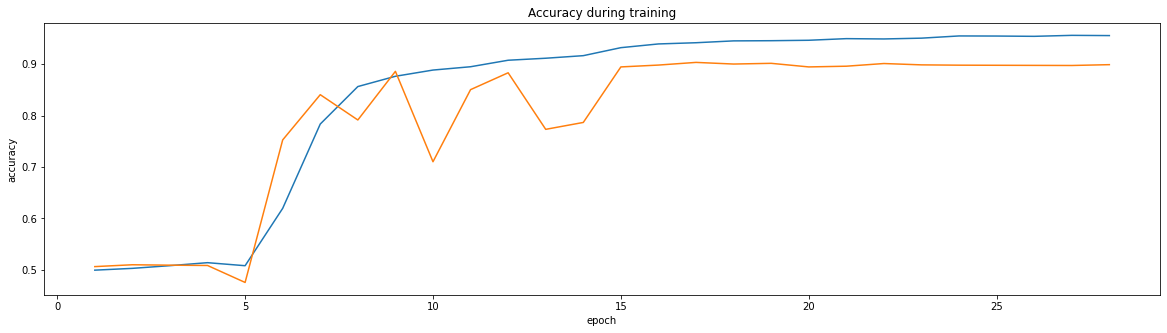

In [ ]:
import matplotlib.pyplot as plt

def showAccuracyHistory(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20,5))
  plt.plot(epochs, acc, label = 'accuracy')
  plt.plot(epochs, val_acc, label = 'val_acc')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy during training')
  plt.show()

showAccuracyHistory(history)

##Confusion Matrix Calculation
###Using Sklearn 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

predictions = list(multi_branch_model.predict(x_test))
predictions = list(map(int, list(map(np.round, predictions))))

cm = confusion_matrix(y_test, predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



Confusion matrix, without normalization
[[11278  1222]
 [ 1600 10900]]


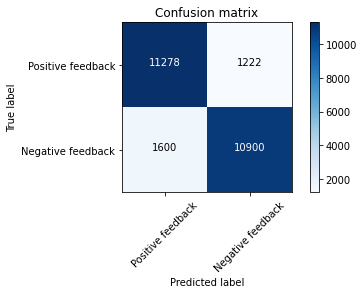

In [ ]:
plot_confusion_matrix(cm, ['Positive feedback', 'Negative feedback'])

In [ ]:
print("Test data accuracy:", (cm[0,0]+cm[1,1])/np.sum(cm)*100,"%")


Test data accuracy: 88.712 %


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

In [ ]:
plot_history(history)

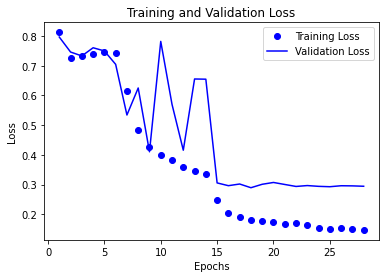

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

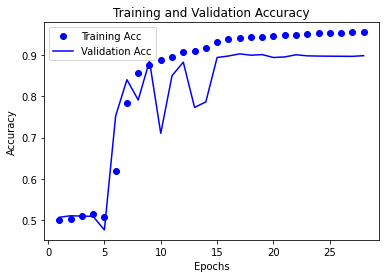

In [ ]:
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Test the model
test_results = multi_branch_model.evaluate(x_test, y_test, verbose=True)
print(f'Output of Test --> Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

782/782 [==============================] - 17s 21ms/step - loss: 0.3216 - accuracy: 0.8871
Output of Test --> Loss: 0.32163211703300476 - Accuracy: 88.7120008468628%
